In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
matplotlib.rc('font', family='Malgun Gothic')

import import_ipynb
from optimizer import *
from dataset2 import spiral, ptb, sequence
from layers_collection import *
from Neural_Network import neural_network
from DeepLearning2_modules import *
from layers_collection2 import *
from negative_sampling_layer import NegativeSamplingLoss
from time_layers_collection import *
from trainer import *
from modules_for_attention import *

C:\ana3\envs\t_f2.2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ana3\envs\t_f2.2\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ana3\envs\t_f2.2\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


importing Jupyter notebook from optimizer.ipynb
importing Jupyter notebook from layers_collection.ipynb
importing Jupyter notebook from Neural_Network.ipynb
importing Jupyter notebook from DeepLearning2_modules.ipynb
importing Jupyter notebook from layers_collection2.ipynb
importing Jupyter notebook from negative_sampling_layer.ipynb
importing Jupyter notebook from time_layers_collection.ipynb
importing Jupyter notebook from trainer.ipynb
importing Jupyter notebook from modules_for_attention.ipynb


## ch.8 Attention

#### Decoder first enhancement -> Weight Sum layer

In [2]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cahce = None
    
    def forward(self,hs,a):
        N,T,H = hs.shape
        
        ar = a.reshape(N,T,1).repeat(H,axis=2)
        t = hs*ar
        c = np.sum(t,axis=1)
        
        self.cache = (hs,ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N,T,H = hs.shape
        
        dt = dc.reshape(N,1,H).repeat(T,axis=1)
        dar = dt*hs
        dhs = dt*ar
        da = np.sum(dar,axis=2)
        
        return dhs, da

#### Decoder second enhancement -> attention weight layer

In [3]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
    
    def forward(self,hs, h):
        N,T,H = hs.shape
        
        hr = h.reshape(N,1,H).repeat(T,axis=1)
        t = hs*hr
        s = np.sum(t,axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs,hr)
        
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N,T,H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N,T,1).repeat(H,axis=2)
        dhs = dt*hr
        dhr = dt*hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

#### merge weight sum layer  + attention weight layer

In [4]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
    
    def forward(self, hs,h):
        a = self.attention_weight_layer.forward(hs,h)
        out = self.weight_sum_layer.forward(hs,a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [5]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [],[]
        self.layers = None
        self.attention_weights = None
    
    def forward(self,hs_enc, hs_dec):
        N,T,H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for i in range(T):
            layer = Attention()
            out[:,i,:] = layer.forward(hs_enc,hs_dec[:,i,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
    
        return out
    
    def backward(self,dout):
        N,T,H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:,t,:])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh
        
        return dhs_enc, dhs_dec

In [6]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(2*H,V)/np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self,xs ,enc_hs):
        
        h = enc_hs[:,-1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c,dec_hs),axis=2)
        score = self.affine.forward(out)
        return score
    
    def backward(self,dscore):
        dout = self.affine.backward(dscore)
        N,H,H2 = dout.shape
        H = H2 //2
        
        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:,-1] += dh
        self.embed.backward(dout)
        
        return denc_hs
    
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:,-1]
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1,1))
            
            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out =np.concatenate((c,dec_hs),axis=2)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)
        
        return sampled
    

class AttentionSeq2seq(seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def save_params(self, file_name = 'attention_lm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name = 'attention_lm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

#### attention seq2seq

In [8]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:,::-1], x_test[:,::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size =256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list= []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train,max_epoch=1,
                batch_size = batch_size, max_grad = max_grad, eval_interval=150)
    correct_num =0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, 
                                    id_to_char, verbose, is_reverse=True)
    acc= float(correct_num)/len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%'%(acc*100))

    
import pickle
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 151 / 351 | 시간 125[s] | 손실 1.62
| 에폭 1 |  반복 301 / 351 | 시간 247[s] | 손실 1.02
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
X 1978-08-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
X 1978-08-11
---
Q october 6, 1992              
T 1992-10-06
X 1978-08-11
---
Q 8/23/08                      
T 2008-08-23
X 1978-08-11
---
Q 8/30/07                      
T 2007-08-30
X 1978-08-11
---
Q 10/28/13                     
T 2013-10-28
X 1978-08-11
---
Q sunday, november 6, 2016     
T 2016-11-06
X 1978-08-11
---
val acc 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.00
| 에폭 2 |  반복 151 / 351 | 시간 129[s] | 손실 0.99
| 에폭 2 |  반복 301 / 351 | 시간 259[s] | 손실 0.86
Q 10/15/94                     
T 1994-10-15
O 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11

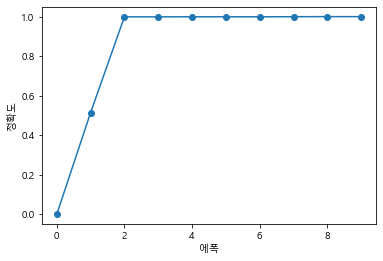

In [9]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

#### peekySeq2seq

In [10]:
peeky_model = Peekyseq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(peeky_model,optimizer)

peeky_acc_list= []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train,max_epoch=1,
                batch_size = batch_size, max_grad = max_grad, eval_interval=150)
    correct_num =0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(peeky_model, question, correct, 
                                    id_to_char, verbose, is_reverse=True)
    acc= float(correct_num)/len(x_test)
    peeky_acc_list.append(acc)
    print('val acc %.3f%%'%(acc*100))


| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 151 / 351 | 시간 56[s] | 손실 1.70
| 에폭 1 |  반복 301 / 351 | 시간 113[s] | 손실 1.04
Q 10/15/94                     
T 1994-10-15
X 1991-01-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1996-02-12
---
Q Mar 25, 2003                 
T 2003-03-25
X 1975-05-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
X 1996-02-12
---
Q Saturday, July 18, 1970      
T 1970-07-18
X 1996-06-09
---
Q october 6, 1992              
T 1992-10-06
X 1991-11-11
---
Q 8/23/08                      
T 2008-08-23
X 1986-05-05
---
Q 8/30/07                      
T 2007-08-30
X 1986-05-05
---
Q 10/28/13                     
T 2013-10-28
X 1991-01-11
---
Q sunday, november 6, 2016     
T 2016-11-06
X 1996-02-12
---
val acc 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 0.98
| 에폭 2 |  반복 151 / 351 | 시간 50[s] | 손실 0.94
| 에폭 2 |  반복 301 / 351 | 시간 100[s] | 손실 0.84
Q 10/15/94                     
T 1994-10-15
X 1983-10-24
---
Q thursday, november 13, 2008  
T 2008-11-1

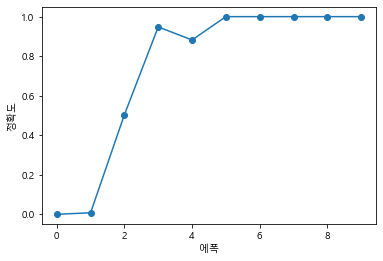

In [11]:
x = np.arange(len(peeky_acc_list))
plt.plot(x, peeky_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

#### naive Seq2seq

In [12]:
naive_model = seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(naive_model,optimizer)

naive_acc_list= []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train,max_epoch=1,
                batch_size = batch_size, max_grad = max_grad, eval_interval=150)
    correct_num =0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(naive_model, question, correct, 
                                    id_to_char, verbose, is_reverse=True)
    acc= float(correct_num)/len(x_test)
    naive_acc_list.append(acc)
    print('val acc %.3f%%'%(acc*100))


| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 151 / 351 | 시간 42[s] | 손실 1.77
| 에폭 1 |  반복 301 / 351 | 시간 86[s] | 손실 1.05
Q 10/15/94                     
T 1994-10-15
X 1977-01-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1977-01-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1977-01-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
X 1977-01-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
X 1977-01-11
---
Q october 6, 1992              
T 1992-10-06
X 1977-01-11
---
Q 8/23/08                      
T 2008-08-23
X 1977-01-11
---
Q 8/30/07                      
T 2007-08-30
X 1977-01-11
---
Q 10/28/13                     
T 2013-10-28
X 1977-01-11
---
Q sunday, november 6, 2016     
T 2016-11-06
X 1977-01-11
---
val acc 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.01
| 에폭 2 |  반복 151 / 351 | 시간 42[s] | 손실 1.00
| 에폭 2 |  반복 301 / 351 | 시간 82[s] | 손실 0.99
Q 10/15/94                     
T 1994-10-15
X 1999-08-21
---
Q thursday, november 13, 2008  
T 2008-11-13


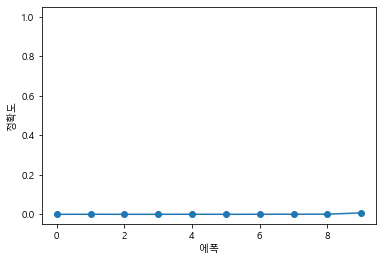

In [13]:
x = np.arange(len(naive_acc_list))
plt.plot(x, naive_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

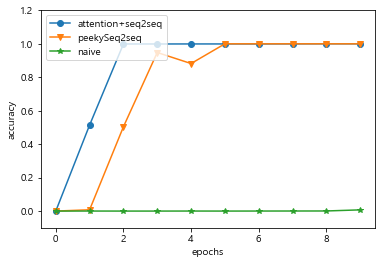

In [16]:
plt.plot(np.arange(len(acc_list)), acc_list, marker='o')
plt.plot(np.arange(len(peeky_acc_list)), peeky_acc_list, marker='v')
plt.plot(np.arange(len(naive_acc_list)), naive_acc_list, marker='*')
plt.legend(['attention+seq2seq', 'peekySeq2seq', 'naive'], loc='upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.1, 1.2)
plt.show()

### visualize attention

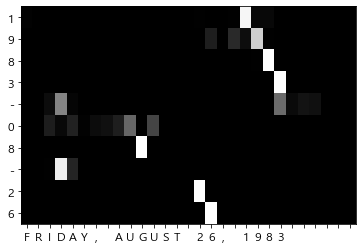

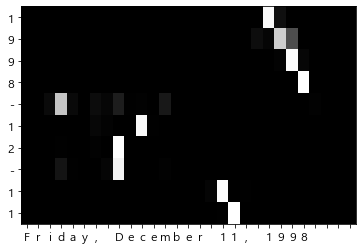

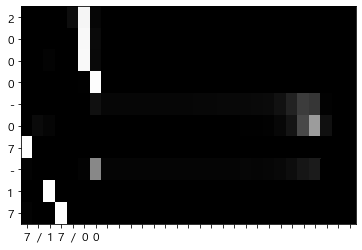

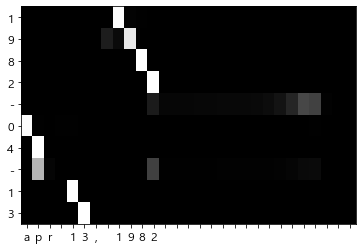

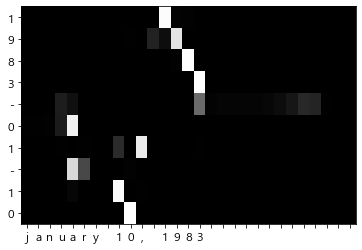

In [7]:
import pickle
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)

(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

### Bi-LSTM

In [13]:
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])  # backward를 위해 입력데이터 반전
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)  # forward, backward concat
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs
    
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None
